# Проект

## Библиотеки

In [5]:
import pandas as pd
import numpy as np

import datetime
from datetime import datetime

from tqdm.auto import tqdm, trange
from copy import copy, deepcopy

import yfinance as yf

import sys
import warnings
warnings.simplefilter("ignore")
from tqdm.auto import tqdm


import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set_style('whitegrid')

In [6]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS
import lightgbm as lgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
folder = '/content/drive/MyDrive/RM_project/'

In [9]:
random_seed = 42
np.random.RandomState(seed=random_seed)

RandomState(MT19937) at 0x7F89FA765440

In [10]:
from stoch_models_and_prediction import *
#from data_stats import reduce_with_pca

## Загрузка данных

In [11]:
data = pd.read_excel(folder+'Final_data.xlsx')
# data = pd.read_excel('./Final_data.xlsx')

In [12]:
print(data.shape, '\n')

print(data.columns, '\n')

(2922, 32) 

Index(['Date', 'Курс доллара', 'Курс евро', 'Нефть', 'МосБиржа', 'РТС',
       'Золото', 'Серебро', 'Платина', 'КБД 0.25', 'КБД 0.5', 'КБД 1', 'КБД 5',
       'КБД 10', 'КБД 15', 'КБД 20', 'КБД 30', 'ОФЗ_26207', 'ОФЗ_26215',
       'ОФЗ_26218', 'ОФЗ_26219', 'ОФЗ_26222', 'Аэрофлот', 'Газпром',
       'ГМК Норникель', 'Лукойл', 'МТС', 'ПИК', 'Роснефть', 'Сбербанк',
       'Татнефть', 'Яндекс'],
      dtype='object') 



In [13]:
# Заполнение пропусков
data.fillna(method='bfill', inplace=True)
data.fillna(method='ffill', inplace=True)

### Разбиение данных

In [14]:
def split_data(df, split_date, start_date=None, end_date=None):
    train = df[df.Date <= split_date]
    test = df[df.Date > split_date]
    if start_date is not None:
        train = train[train.Date >= start_date]
    if end_date is not None:
        test = test[test.Date <= end_date]
    return train, test

In [15]:
#разбиваем данные на train и test по дате

#df_train, df_test = split_data(data, split_date='2022-06-09')
#print(df_train.shape[0], df_test.shape[0])

## Часть 4: оценка справедливой стоимости

Портфель состоит из инструментов.\
Инструменты:
1. Облигации (5 шт. по 10 млн.руб.)
2. Акции (10 шт. по 1 млн. руб.)
3. Валюта (доллар и евро, по 100 млн. руб.)

Риск-факторы влияют на стоимость инструментов.

Для предсказания стоимости по риск-факторам используются линейная регрессия и LightGBM. Также стоимость считается на основе стохастических моделей из пункта 3.

### Валюта

In [16]:
risk_factors_1 = ['Нефть', 'МосБиржа', 'РТС', 'Золото', 'Серебро', 'Платина', 'КБД 0.25', 'КБД 1', 'КБД 5', 'КБД 10', 'КБД 20']

currency = ['Курс доллара', 'Курс евро']

In [24]:
FV_dol = Fair_value_measurement(target_name=currency[0], factors_name = risk_factors_1, df=data, last_date= '2022-12-02',
                                n_steps=10, N_traj=100)
res1 = FV_dol.get_best_prediction()

  0%|          | 0/11 [00:00<?, ?it/s]

In [25]:
print(res1.shape)

(100, 10)


In [26]:
res1

array([[60.46244554, 60.89090242, 61.86749111, 61.99087663, 60.72454191,
        60.70760507, 61.10556458, 61.05659609, 61.11910683, 60.8773397 ],
       [60.46244554, 61.1694647 , 61.06034339, 61.06021245, 60.86057207,
        61.09230137, 61.90893995, 61.48608338, 61.49139991, 61.32873181],
       [60.46244554, 64.10557806, 65.22317369, 65.56063286, 65.21877766,
        65.05557498, 65.43992294, 65.27561449, 65.23955027, 65.73306518],
       [60.46244554, 62.12702177, 61.63487965, 61.36408853, 61.29449628,
        60.66271346, 60.7069063 , 61.7338231 , 61.68135694, 61.70995213],
       [60.46244554, 60.88642157, 60.89171338, 61.08529371, 61.19693855,
        61.25933116, 61.55575868, 61.38221595, 61.08014599, 61.1900311 ],
       [60.46244554, 60.56598367, 60.49101499, 63.52499406, 61.95335644,
        64.61432211, 64.18277565, 63.99284794, 63.9442708 , 63.98096184],
       [60.46244554, 61.62670568, 60.54314995, 60.57358313, 60.71582602,
        62.13283225, 61.92610274, 61.13637631

### Акции

In [19]:
risk_factors_2 = ['Курс доллара', 'Курс евро', 'Нефть', 'МосБиржа', 'РТС',
       'Золото', 'Серебро', 'Платина', 'КБД 0.25', 'КБД 1', 'КБД 5', 'КБД 10', 'КБД 20']

stocks = ['Аэрофлот', 'Газпром', 'ГМК Норникель', 'Лукойл', 'МТС', 'ПИК', 'Роснефть', 'Сбербанк', 'Татнефть', 'Яндекс']

  0%|          | 0/13 [00:00<?, ?it/s]

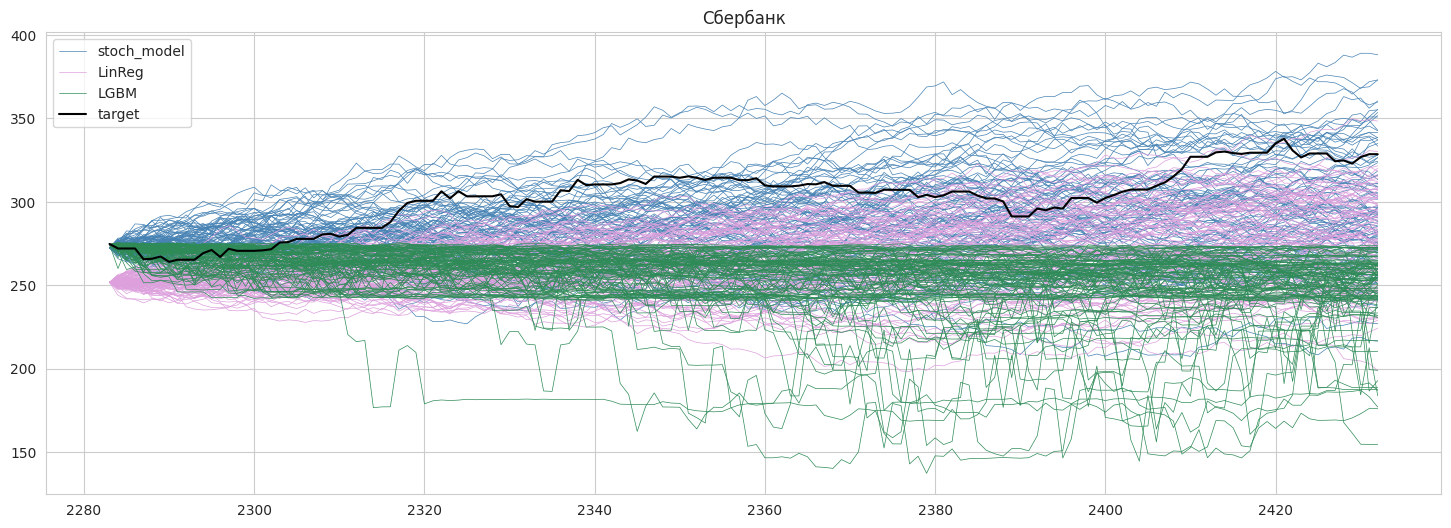

In [27]:
FV_sber = Fair_value_measurement(target_name=stocks[7], factors_name = risk_factors_2, df=data, last_date= '2021-04-01', n_steps=150, N_traj=100)
FV_sber.make_predictions(plot=1)

In [28]:
res2 = FV_sber.get_best_prediction()

### Облигации

In [31]:
bonds = ['ОФЗ_26207', 'ОФЗ_26215', 'ОФЗ_26218', 'ОФЗ_26219', 'ОФЗ_26222']

  0%|          | 0/13 [00:00<?, ?it/s]

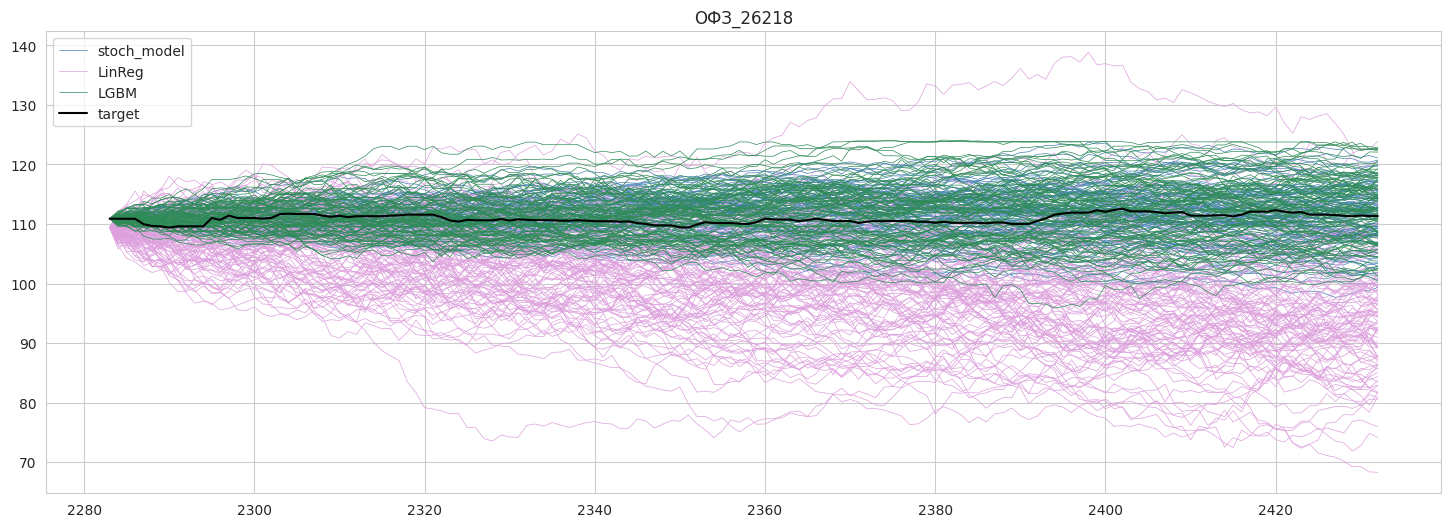

In [32]:
FV_b18 = Fair_value_measurement(target_name=bonds[2], factors_name = risk_factors_2, df=data, last_date= '2021-04-01', n_steps=150)
FV_b18.make_predictions(plot=1)